# Swinging Door #

Реализация алгоритма Swinging Door на Python.

Литература:
 * [Патент US4669097](https://patents.google.com/patent/US4669097 "patents.google.com");
 * [Swinging Door Trending Compression Algorithm for IoT Environments](https://sol.sbc.org.br/index.php/sbesc_estendido/article/download/8650/8551/#:~:text=The%20Swing%20Door%20Trending%20(SDT,process%20information%20systems%20(PIMs). "sol.sbc.org.br");
 * [Компрессия данных в системах промышленной автоматизации. Алгоритм SwingingDoor](https://habr.com/ru/post/105652/ "habr.com");

Реализация:

In [1]:
class Point():
    def __init__(self, *args):
        self.x = args[0]
        self.y = args[1]
    
    def __call__(self):
        return self.x, self.y

def swinging_door(data, deviation=.1):
    cd = deviation
    c = d = Point(*data.__next__())
    
    u = Point(c.x, c.y + cd)
    l = Point(c.x, c.y - cd)
    
    su_max = sl_min = None
    
    yield c()
    
    while True:
        p = d
        
        try:
            d = Point(*data.__next__())
        
        except StopIteration:
            break
        
        su = (d.y - u.y) / (d.x - u.x)
        sl = (d.y - l.y) / (d.x - l.x)
        
        if not su_max and not sl_min:
            su_max = su
            sl_min = sl
            
            continue
            
        if su > su_max:
            su_max = su
            
            if su_max > sl_min:
                so = (d.y - p.y) / (d.x - p.x)
                cu = (u.y - p.y + so * p.x - sl_min * u.x) / (so - sl_min)
                c = Point(cu, u.y + sl_min * (cu - u.x) - cd / 2)
                
                yield c()
                
                u = Point(c.x, c.y + cd)
                l = Point(c.x, c.y - cd)
                
                su_max = su = (d.y - u.y) / (d.x - u.x)
                sl_min = sl = (d.y - l.y) / (d.x - l.x)
        
        elif sl < sl_min:
            sl_min = sl
            
            if su_max > sl_min:
                so = (d.y - p.y) / (d.x - p.x)
                cl = (l.y - p.y + so * p.x - su_max * l.x) / (so - su_max)
                c = Point(cl, l.y + su_max * (cl - l.x) + cd / 2)
                
                yield c()
                
                u = Point(c.x, c.y + cd)
                l = Point(c.x, c.y - cd)
                
                su_max = su = (d.y - u.y) / (d.x - u.x)
                sl_min = sl = (d.y - l.y) / (d.x - l.x)
    
    if p:
        yield p()

Постройка графика из сырых данных:

8737


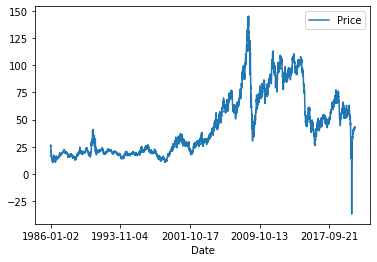

In [2]:
%matplotlib inline

from datetime import datetime
from sys import stderr

from pandas import read_csv, DataFrame

def get_data(data):
    for date, value in data.values.tolist():
        yield datetime.strptime(date, "%Y-%m-%d").timestamp(), value

df = read_csv("https://datahub.io/core/oil-prices/r/wti-daily.csv")

print(len(df), file=stderr)
df.plot(x="Date", y="Price")

Постройка графика из прореженных данных:

2585


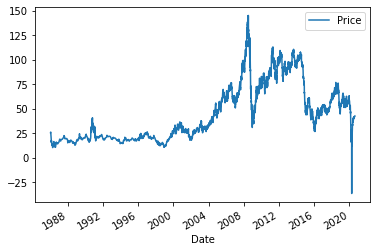

In [3]:
compress = DataFrame(
    tuple(
        {
            "Date": datetime.fromtimestamp(date),
            "Price": value
        }
        for date, value in swinging_door(
            get_data(df), deviation=.5
        )
    )
)

print(len(compress), file=stderr)
compress.plot(x="Date", y="Price")